In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import glob as glob
import re 
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from array import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit

In [2]:
def pattern_to_float(file_path,pattern = r'_(-)*\d(\d)?(\d)?(\d)?(\d)?_uA'): 
    current_deg_ex = re.compile(pattern)
    current_val = current_deg_ex.search(file_path)
    current_val_float = float(current_val.group().split('_')[1])
    return current_val_float

In [3]:
class resonance:
    def get_curr(self,file_name):
        current_deg_ex = re.compile(r'Curr_(-)*\d(\d)?(\d)?(\d)?(\d)?_uA')
        current_val = current_deg_ex.search(file_name)
        current_val_float = float(current_val.group().split('_')[1])
        return current_val_float

    def complex_lorentz(self,f,f_0, A,gamma, phi):
        return A*np.exp(1j*phi)*(gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2)
    
    def vec_model(self,f,f_0, A,gamma, phi):
        real_part = np.real(self.complex_lorentz(f,f_0, A,gamma, phi))
        imag_part = np.imag(self.complex_lorentz(f,f_0, A,gamma, phi)) 
        return np.hstack([real_part,imag_part])
    def complex_lorentz_lin_back(self,f,f_0, A,gamma, phi, a_real, b_real, a_imag, b_imag):
        lor = A*np.exp(1j*phi)*(gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2)
        back = (a_real + 1j*a_imag)*f + (b_real + 1j*b_imag)
        return lor + back 
    # TEST - testowanie najlepszego modelu, w którym dodajemy liniowe tło do lorentzianu
    # te definicje są do usunięcia docelowo
    
    def complex_lorentz_TEST(self,f,f_0, A,gamma, phi, a, b):
        return A*np.exp(1j*phi)*( (gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2) + a*f+b )
    
    def vec_model_TEST(self,f,f_0, A,gamma, phi, a, b):
        real_part = np.real(self.complex_lorentz_TEST(f,f_0, A,gamma, phi, a, b))
        imag_part = np.imag(self.complex_lorentz_TEST(f,f_0, A,gamma, phi, a, b)) 
        return np.hstack([real_part,imag_part])
    
    def complex_lorentz_TEST2(self,f,f_0, A,gamma, phi, a, b):
        return A*np.exp(1j*phi)*( (gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2)) + (a*f+b)*(1+1j)
    
    def vec_model_TEST2(self,f,f_0, A,gamma, phi, a, b):
        real_part = np.real(self.complex_lorentz(f,f_0, A,gamma, phi)) + a*f+b
        imag_part = np.imag(self.complex_lorentz(f,f_0, A,gamma, phi)) + a*f+b
        return np.hstack([real_part,imag_part])
    
    def complex_lorentz_TEST3(self,f,f_0, A,gamma, phi, a_real, b_real, a_imag, b_imag):
        return A*np.exp(1j*phi)*( (gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2)) + (a_real*f+b_real) + 1j*(a_imag*f+b_imag)
    
    def vec_model_TEST3(self,f,f_0, A,gamma, phi, a_real, b_real, a_imag, b_imag):
        real_part = np.real(self.complex_lorentz(f,f_0, A,gamma, phi)) + a_real*f+b_real
        imag_part = np.imag(self.complex_lorentz(f,f_0, A,gamma, phi)) + a_imag*f+b_imag
        return np.hstack([real_part,imag_part])
    
    def lorentzian_fit_TEST(self, gamma = 1e-3,phi = 0, a = 0, b = 0):
        meas_real = self.X
        meas_imag = self.Y
        meas = np.hstack([meas_real,meas_imag])
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]
        popt, pcov = curve_fit(self.vec_model_TEST,self.freq,meas, p0 = [f_guess,A_guess,gamma,phi,a,b])
        self.fit_opt = popt
        self.cov = pcov
        self.t2_s = 1/popt[2]
        self.t2_min = (1/(60*popt[2]))
        
        plt.plot(self.freq, self.R)
        plt.plot(self.freq, np.abs(self.complex_lorentz_TEST(self.freq,*self.fit_opt)))
        plt.show()
        
        plt.plot(self.freq, np.abs(self.complex_lorentz_TEST(self.freq,*self.fit_opt)) - self.R)
        plt.show()
        
        return popt, pcov
    
    def lorentzian_fit_TEST2(self, gamma = 1e-3,phi = 0, a = 0, b = 0):
        meas_real = self.X
        meas_imag = self.Y
        meas = np.hstack([meas_real,meas_imag])
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]
        popt, pcov = curve_fit(self.vec_model_TEST,self.freq,meas, p0 = [f_guess,A_guess,gamma,phi,a,b])
        self.fit_opt = popt
        self.cov = pcov
        self.t2_s = 1/popt[2]
        self.t2_min = (1/(60*popt[2]))
        
        plt.plot(self.freq, self.R)
        plt.plot(self.freq, np.abs(self.complex_lorentz_TEST2(self.freq,*self.fit_opt)))
        plt.show()
        
        plt.plot(self.freq, np.abs(self.complex_lorentz_TEST2(self.freq,*self.fit_opt)) - self.R)
        plt.show()
        
        return popt, pcov
    
    def lorentzian_fit_TEST3(self, gamma = 1e-3,phi = 0, a_real = 0, b_real = 0, a_imag = 0, b_imag = 0):
        meas_real = self.X
        meas_imag = self.Y
        meas = np.hstack([meas_real,meas_imag])
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]
        popt, pcov = curve_fit(self.vec_model_TEST3,self.freq,meas,
                               p0 = [f_guess,A_guess,gamma,phi,a_real,b_real,a_imag,b_imag])
        self.fit_opt = popt
        self.cov = pcov
        self.t2_s = 1/popt[2]
        self.t2_min = (1/(60*popt[2]))
        
        plt.plot(self.freq, self.R)
        plt.plot(self.freq, np.abs(self.complex_lorentz_TEST3(self.freq,*self.fit_opt)))
        plt.show()
        
        plt.plot(self.freq, np.abs(self.complex_lorentz_TEST3(self.freq,*self.fit_opt)) - self.R)
        plt.show()
        
        return popt, pcov
    
    # koniec testów
    
    # model which was called Test 3 
    # single Lorenzian + linear (complex) background
    def vec_model_lor_lin_back(self,f,f_0, A,gamma, phi, a_real, b_real, a_imag, b_imag):
        real_part = np.real(self.complex_lorentz(f,f_0, A,gamma, phi)) + a_real*f+b_real
        imag_part = np.imag(self.complex_lorentz(f,f_0, A,gamma, phi)) + a_imag*f+b_imag
        return np.hstack([real_part,imag_part])    
    def complex_lorentz_serf(self, f, f_0, A, phi, g_a, g_b, g_c):
        gamma = g_a*f**2 +g_b*f +g_c
        return A*np.exp(1j*phi)*(gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2)
    
    def vec_model_serf(self,f,f_0, A, phi,g_a, g_b, g_c):
        real_part = np.real(self.complex_lorentz_serf(f,f_0, A, phi, g_a, g_b, g_c))
        imag_part = np.imag(self.complex_lorentz_serf(f,f_0, A, phi, g_a, g_b, g_c))  
        return np.hstack([real_part,imag_part])
    
    def find_ind(self, f_min = 0.1,f_max = 6): # nie rozumiem co to robi - Grzesiek
        ind_1 = np.where(self.freq >= f_min)
        ind_2 = np.where(self.freq <= f_max)
        self.ind = np.intersect1d(ind_1,ind_2)
    
    # fitting of the complex lorentzian
    # dodaję model z Test 3
    def complex_lorentzian_fit(self,
                               # Lorentz starting parameters                               
                               gamma = 1e-3,
                               phi = 0,
                               # linear background starting parameters
                               a_real = 0,
                               b_real = 0,
                               a_imag = 0,
                               b_imag = 0,
                               # fir model choise
                               fit_model = 'Lin background'):
        meas_real = self.X
        meas_imag = self.Y
        meas = np.hstack([meas_real,meas_imag])
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]
        if fit_model == 'Lin background':
                popt, pcov = curve_fit(self.vec_model_lor_lin_back,self.freq,meas, 
                                       p0 = [f_guess,A_guess,gamma,phi,a_real,b_real,a_imag,b_imag ])
        elif fit_model == 'Single lorentz':
                popt, pcov = curve_fit(self.vec_model,self.freq,meas, p0 = [f_guess,A_guess,gamma,phi])
        self.fit_opt = popt
        self.cov = pcov
        self.t2_s = 1/popt[2]
        self.t2_min = (1/(60*popt[2]))
        return popt, pcov
    
    # fitting of the complex lorentzian
    # to trzeba będzie wyrzucić kiedy będzie działała func complex_lorentz_fit
    def lorentzian_fit(self, gamma = 1e-3,phi = 0):
        meas_real = self.X
        meas_imag = self.Y
        meas = np.hstack([meas_real,meas_imag])
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]
        popt, pcov = curve_fit(self.vec_model,self.freq,meas, p0 = [f_guess,A_guess,gamma,phi])
        self.fit_opt = popt
        self.cov = pcov
        self.t2_s = 1/popt[2]
        self.t2_min = (1/(60*popt[2]))
        return popt, pcov
            
    def show_R_fit(self, fit_model = 'Lin background'):
            plt.plot(self.freq, self.R)
            if fit_model == 'Lin background':
                plt.plot(self.freq, np.abs(self.complex_lorentz_lin_back(self.freq,*self.fit_opt)))
                
            elif fit_model == 'Single lorentzian':
                plt.plot(self.freq, np.abs(self.complex_lorentz(self.freq,*self.fit_opt)))  
            plt.show()
    # tu trzeba dodać wybór jak wyżej   
    def show_X_fit(self, fit_model = 'Lin background'):
            plt.plot(self.freq, self.X)
            plt.plot(self.freq, np.real(self.complex_lorentz(self.freq,*self.fit_opt)))
            plt.show()
            
    def show_Y_fit(self, fit_model = 'Lin background'):
            plt.plot(self.freq, self.Y)
            plt.plot(self.freq, np.imag(self.complex_lorentz(self.freq,*self.fit_opt)))
            plt.show()
            
    def simple_lor_model(self,f,f_0, A,gamma, phi, a, b):
        return np.real(self.complex_lorentz(f,f_0, A,gamma, phi)) + a * f + b
    
    def simple_lor_fit_X(self, phi = 0, gamma = 11):
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]    
        popt, pcov = curve_fit(self.simple_lor_model, self.freq, self.X , p0 = [f_guess,A_guess,phi, gamma])
        self.simple_fit_opt = popt
        self.simple_fit_cov = cov
        return popt, pcov 
    
    def simple_lor_model_Y(self, f, f_0, A, gamma, phi):
        return np.imag(self.complex_lorentz(f, f_0, A, gamma, phi))
    
    def simple_lor_fit_Y(self, phi = 0, gamma = 11):
        ind_max = np.where(self.R == np.max(self.R))
        A_guess = self.R[ind_max][0]
        f_guess = np.abs(self.freq[ind_max])[0]
        popt, pcov = curve_fit(self.simple_lor_model_Y, self.freq, self.Y, p0 = [f_guess, A_guess, phi, gamma])
        self.simple_fit_Y_opt = popt
        selft.simple_fit_Y_cov = pcov
        return popt, pcov
    
    def show_simple_fit_Y(self):
        plt.plt(self.freq, self.Y)
        plt.plot(self.freq, self.simple_lor_model_Y(self, self.freq, *self.simple_fit_Y_opt))
        plt.show()
        
    def show_Y(self):
        plt.plot(self.freq, self.Y)
        plt.show()
        
    def show_X(self):
        plt.plot(self.freq, self.X)
        plt.show()

# innitialization of the class obgect
    def __init__(self,file_path):
        data = np.loadtxt(file_path)
        self.freq = data[:,0]
        self.X = data[:,1]
        self.Y = data[:,3]
        self.R = data[:,5]
        self.phi = data[:,7]
        current_deg_ex = re.compile(r'_(-)*\d(\d)?(\d)?(\d)?(\d)?_uA')
        current_val = current_deg_ex.search(file_path)
        current_val_float = float(current_val.group().split('_')[1])
        self.current = current_val_float

In [4]:
# reafing all file names in all directories

polarization_check = "Before degaussing/Rb_polarization_check/"
tuned = "Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/"

all_files = glob.glob(tuned + "**/*.dat",recursive = True)
all_files

['Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_1200_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_1550_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_1900_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_2250_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_2600_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_2950_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz\\pump_1086_mW\\Ch_1__Curr_3300_uA.dat',
 'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_

In [5]:
# reading pump powers
pump_power = []
pump_pattern = r'pump_(-)*\d(\d)?(\d)?(\d)?(\d)?_mW'
for f in all_files:
    pump_power.append(pattern_to_float(f, pattern = pump_pattern ))
    
pump_power = np.array(pump_power)
pump_power = np.unique(pump_power)

In [445]:
#search for filenames

file_names = []
for p in pump_power:
    file_names.append(
        glob.glob(tuned + "/pump_"+str(int(p))+"_mW/*.dat",recursive = True)
    )
file_names

[['Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_1200_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_1550_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_1900_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_2250_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_2600_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_2950_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\\Ch_1__Curr_3300_uA.dat',
  'Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavele

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_1200_uA.dat


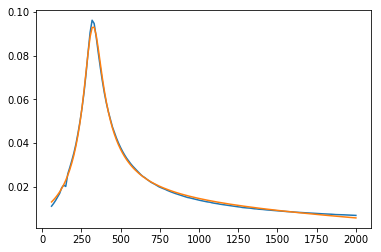

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_1550_uA.dat


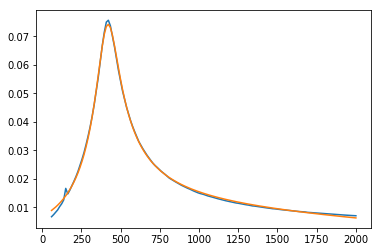

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_1900_uA.dat


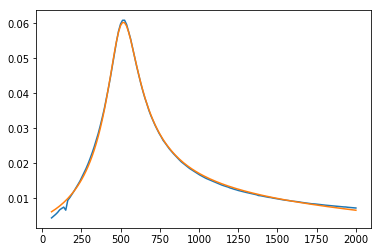

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_2250_uA.dat


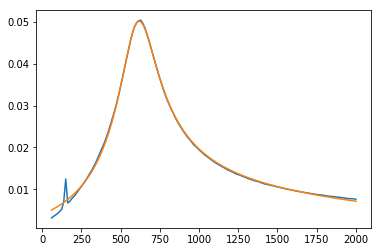

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_2600_uA.dat


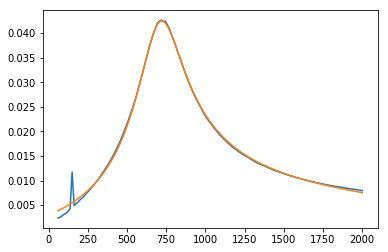

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_2950_uA.dat


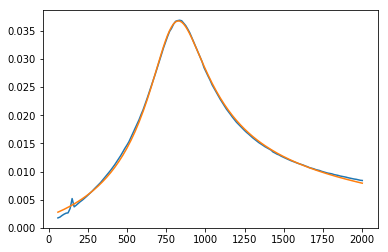

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_3300_uA.dat


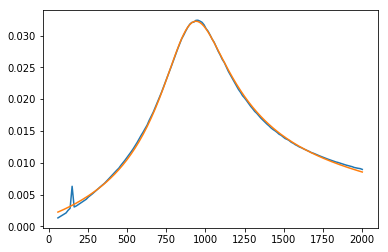

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_3650_uA.dat


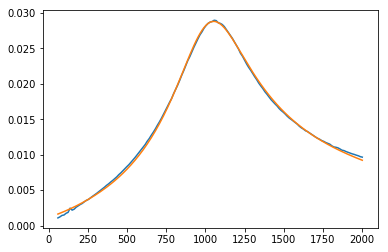

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_4000_uA.dat


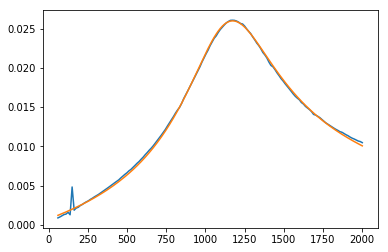

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_500_uA.dat


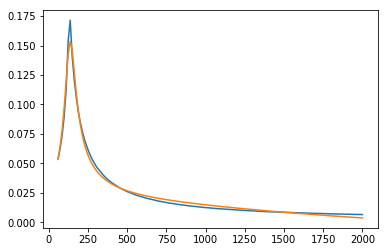

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW\Ch_1__Curr_850_uA.dat


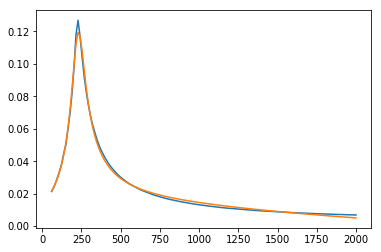

0
Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_1200_uA.dat


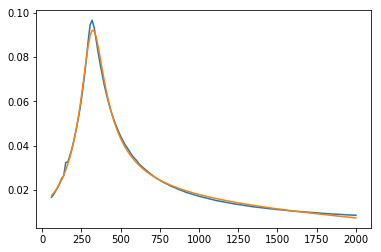

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_1550_uA.dat


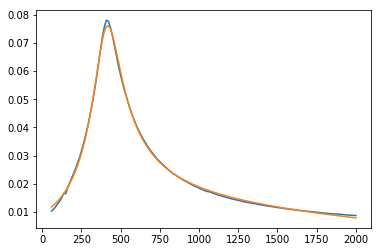

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_1900_uA.dat


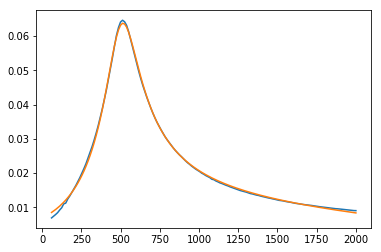

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_2250_uA.dat


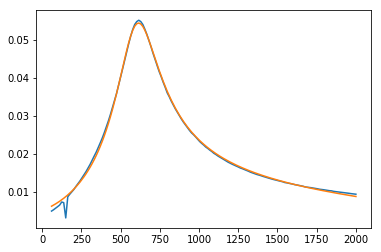

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_2600_uA.dat


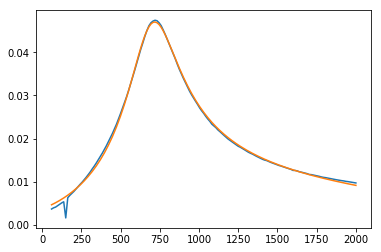

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_2950_uA.dat


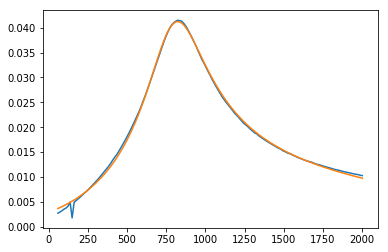

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_3300_uA.dat


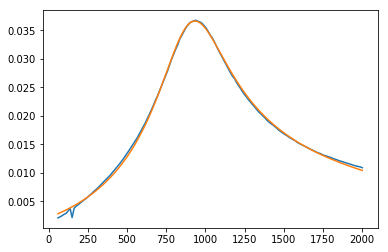

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_3650_uA.dat


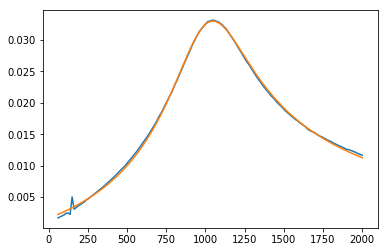

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_4000_uA.dat


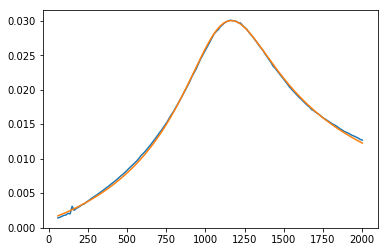

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_500_uA.dat


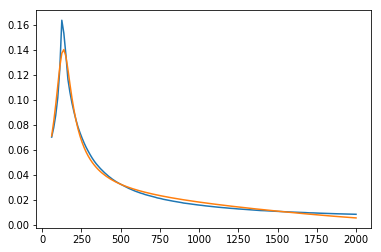

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_262_mW\Ch_1__Curr_850_uA.dat


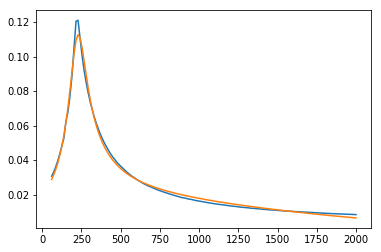

1
Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_1200_uA.dat


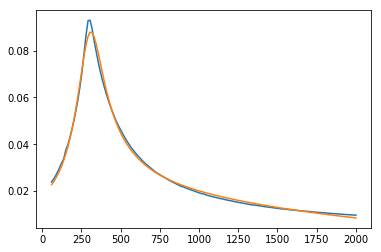

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_1550_uA.dat


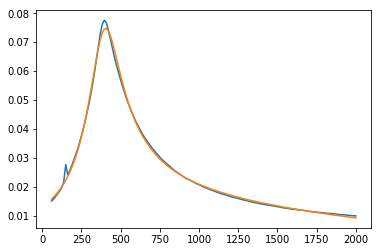

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_1900_uA.dat


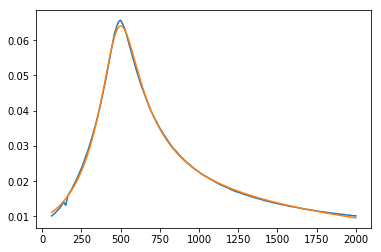

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_2250_uA.dat


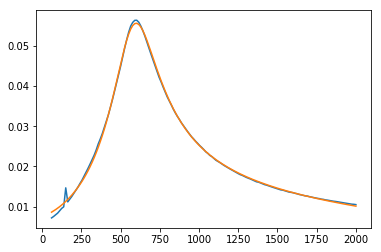

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_2600_uA.dat


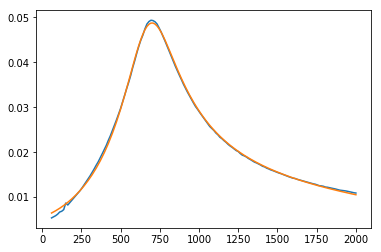

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_2950_uA.dat


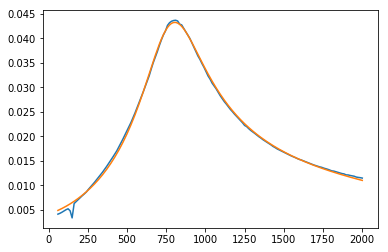

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_3300_uA.dat


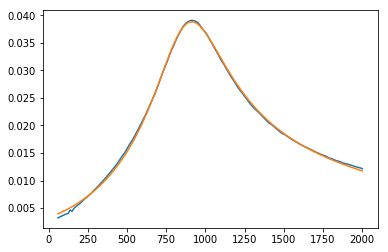

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_3650_uA.dat


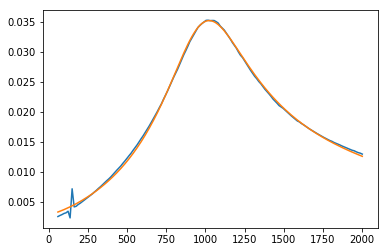

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_4000_uA.dat


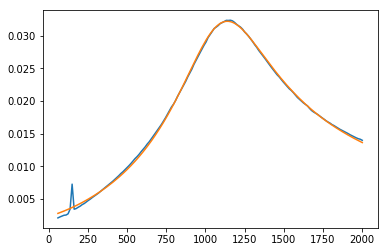

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_500_uA.dat


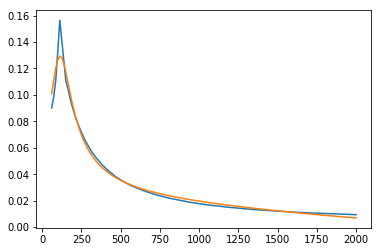

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_509_mW\Ch_1__Curr_850_uA.dat


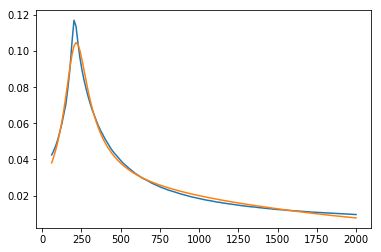

2
Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_1200_uA.dat


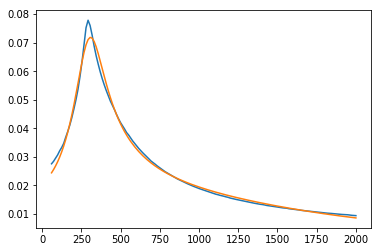

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_1550_uA.dat


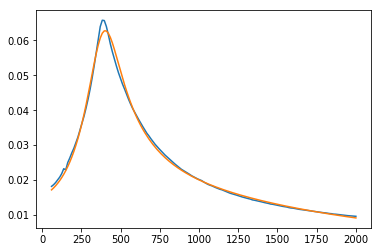

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_1900_uA.dat


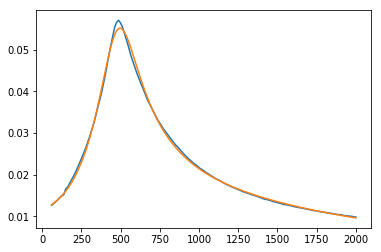

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_2250_uA.dat


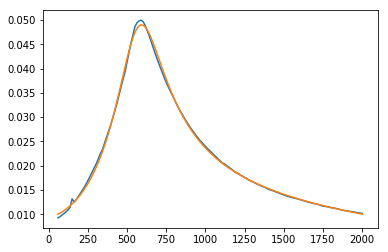

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_2600_uA.dat


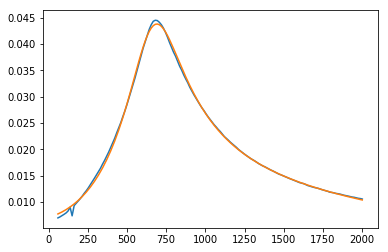

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_2950_uA.dat


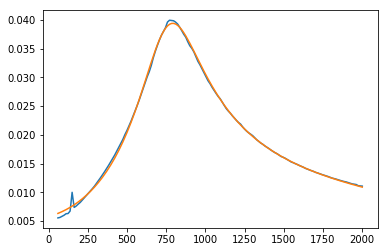

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_3300_uA.dat


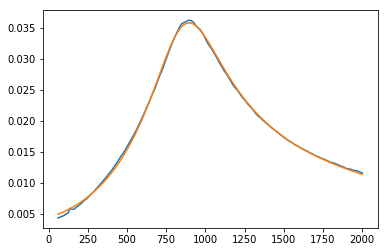

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_3650_uA.dat


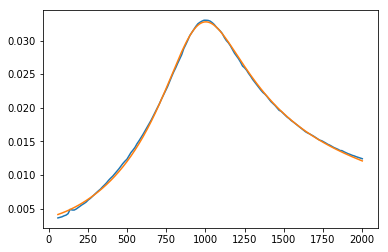

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_4000_uA.dat


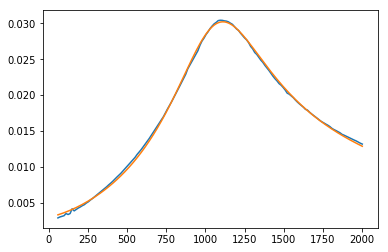

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_500_uA.dat


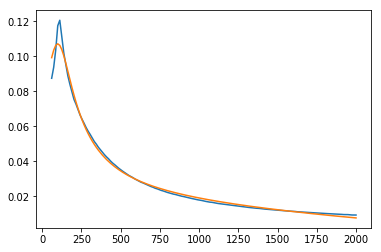

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_1086_mW\Ch_1__Curr_850_uA.dat


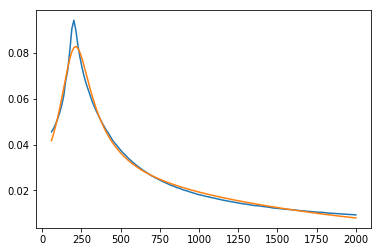

3
Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_1200_uA.dat


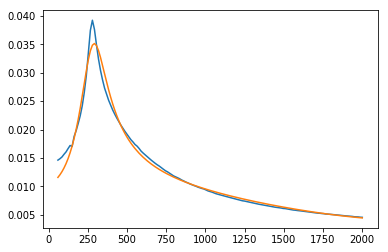

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_1550_uA.dat


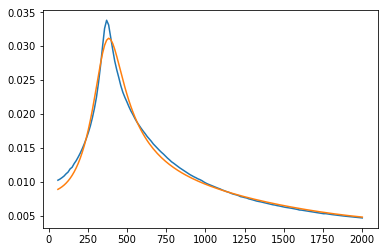

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_1900_uA.dat


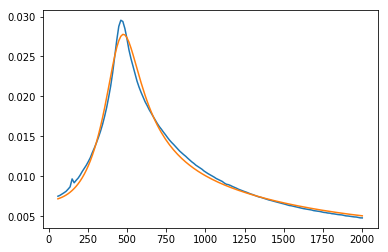

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_2250_uA.dat


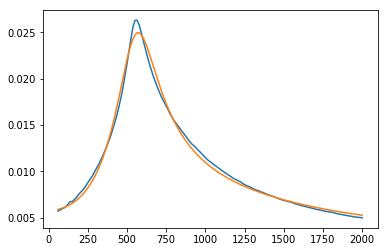

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_2600_uA.dat


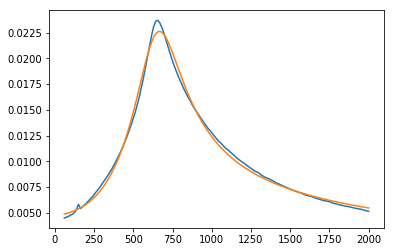

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_2950_uA.dat


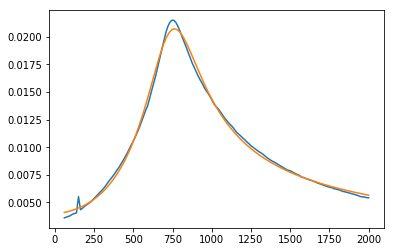

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_3300_uA.dat


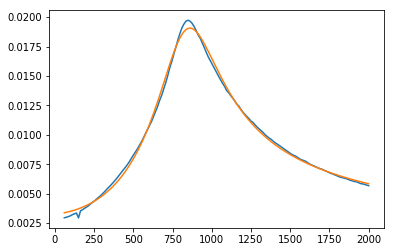

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_3650_uA.dat


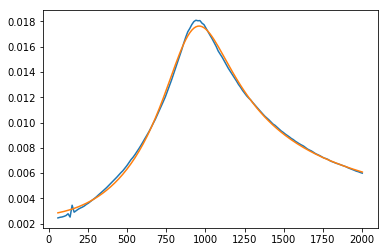

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_4000_uA.dat


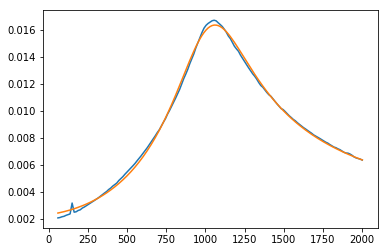

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_500_uA.dat


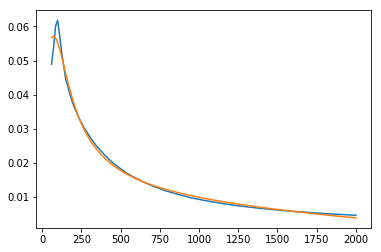

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_2060_mW\Ch_1__Curr_850_uA.dat


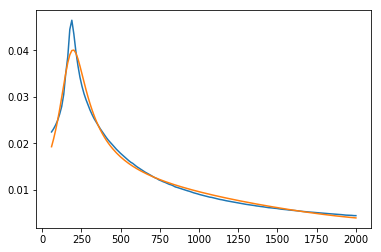

4
Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_1200_uA.dat


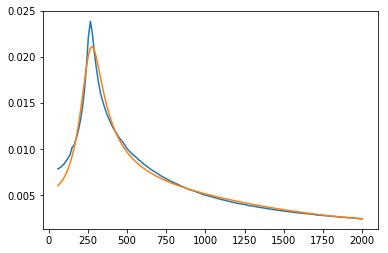

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_1550_uA.dat


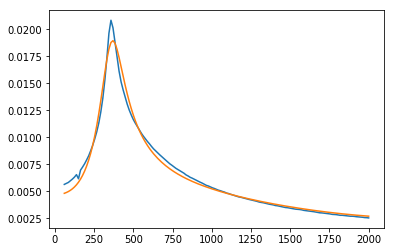

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_1900_uA.dat


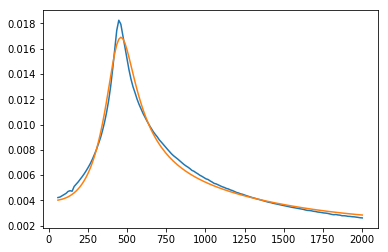

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_2250_uA.dat


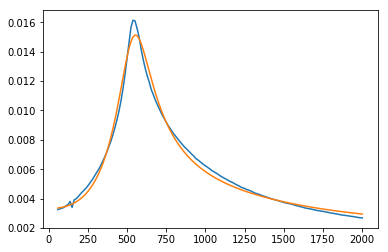

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_2600_uA.dat


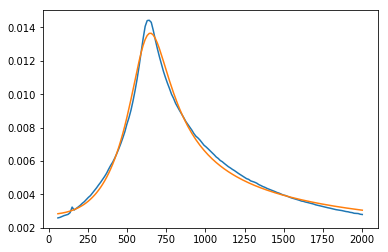

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_2950_uA.dat


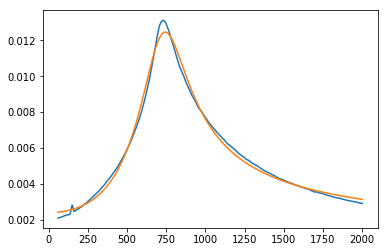

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_3300_uA.dat


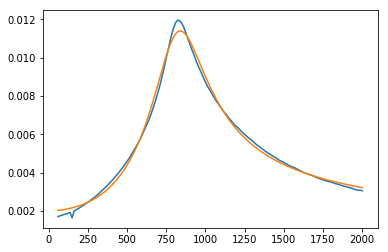

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_3650_uA.dat


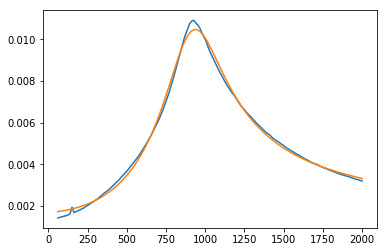

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_4000_uA.dat


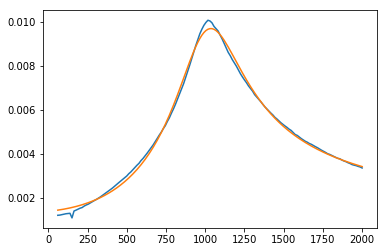

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_500_uA.dat


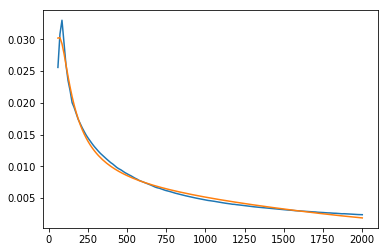

Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_3001_mW\Ch_1__Curr_850_uA.dat


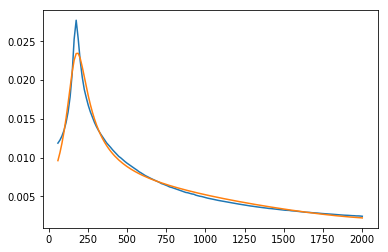

5


In [462]:
i = 0
res = []
freq  = []
curr = []
for fn in file_names:
    #res_out = []
    f = []
    c = []
    for name in fn:
        print(name)
        x = resonance(name)
        x.complex_lorentzian_fit()
        #res_out.append(x)
        x.show_R_fit()
        f.append(x.fit_opt[0])
        c.append(x.current)
    print(i)
    f = np.array(f)
    c = np.array(c)
    f = f[c.argsort()]
    c = c[c.argsort()]
    freq.append(f)
    curr.append(c)
    i = i+1
    #res.append(res_out )

6


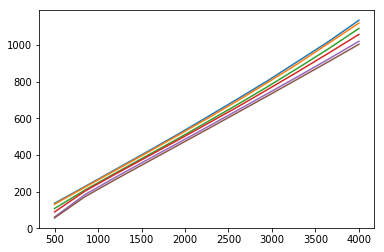

In [505]:
for i in range(len(freq)):
    plt.plot(curr[i],freq[i])
    
#plt.xscale('log')
#plt.yscale('log')
print(len(freq))

[[  0.28331074 -21.24497443]
 [  0.2803704  -22.92003469]
 [  0.27694421 -36.22819595]
 [  0.27157568 -38.66777161]
 [  0.26784994 -53.03449849]
 [  0.26601527 -61.13499385]]


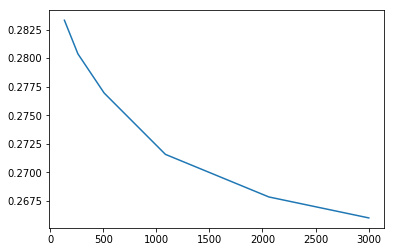

In [507]:
# fitowanie współczynników kierunkowych, czyli czynników żyromagnetycznych (Hz/uA)

lin_mod = lambda c,A,B: A*c+B
lin_fits = []
lin_fits_cov = []
for i in range(len(curr)):
    popt, pcov = curve_fit(lin_mod,curr[i],freq[i] )
    lin_fits.append(popt)
    lin_fits_cov.append(pcov)
lin_fits = np.array(lin_fits)
lin_fits_cov = np.array(lin_fits_cov)

print(lin_fits) # Hz / uA
plt.plot(pump_power,lin_fits[:,0])

In [680]:
# przeliczenie współczynników kierunkowych z Hz/uA na Hz/mG
# cewka w osi X: 56.8 *10**3 nT/A -> uA = 56.8 * 10**(-6) nT = 56.8 * 10**(-6-2) mG
gamma = lin_fits[:,0] * (56.8 *10**3 * 10**(-8))

print(gamma)

[0.00016092 0.00015925 0.0001573  0.00015425 0.00015214 0.0001511 ]


# Wyznaczenie polaryzjacji

Z https://journals.aps.org/pra/pdf/10.1103/PhysRevA.71.023405 mamy dla I = 3/2

$$ \gamma / \gamma_0 = 2 - \frac{4}{3+P^2} $$

Zatem

$$ P = \sqrt{\frac{4}{2 - \gamma/\gamma_0} - 3} $$

Dla $^{39}$K $\gamma_0 = 1.2498 \cdot * 10^7$ rad*Hz/T (http://triton.iqfr.csic.es/guide/eNMR/chem/K.html)

Dla $^{85}$Rb $\gamma_0 = 2.5909 \cdot * 10^7$ rad*Hz/T (http://triton.iqfr.csic.es/guide/eNMR/chem/Rb.html)

Dla $^{87}$Rb $\gamma_0 = 8.7807 \cdot * 10^7$ rad*Hz/T (http://triton.iqfr.csic.es/guide/eNMR/chem/Rb.html)

0.1989118478762508
[0.000809   0.00080061 0.00079082 0.00077549 0.00076486 0.00075962]
[nan nan nan nan nan nan]


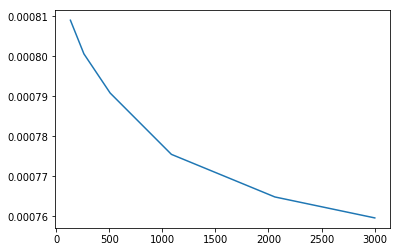

In [682]:
gamma_0 = 1.2498 * 10**7 / (2 * np.pi) / 10**(4) / 10**(3) # Hz/mG
print(gamma_0)
ratio = gamma/gamma_0
pol = np.sqrt(4/(2 - ratio) - 3)
print(ratio)
print(pol)
plt.plot(pump_power,gamma/gamma_0)

In [415]:
# wartości z polarization_check
#lin_fits

array([[  0.2880437 , -19.89676217],
       [  0.2889835 , -15.94218512],
       [  0.28999909, -19.28621075],
       [  0.28303981, -19.57739599],
       [  0.27885635, -28.99937502]])

# field_zeroing()

na wejściu: 

path - ścieżka do katalogu z plikami '...Curr_iii_uA.dat' (zakończona '/')

fit_model - wybór funkcji dopasowywanej do wykresu f(curr) (częstotliwość rezonansowa w funkcji przyłożonego na cewkę prądu, do wyboru: 

    'lin' - moduł funkcji liniowej - do wykorzystania przy cewce X

    'sqrt' - pierwiastek z funkcji kwadratowej - dla pomiarów z polem wiodącym
    
show_frequencies - True/False - pokaż wykres f(curr)

show_lorentz_fit - True/False - pokaż wykresy dopasowania lorentzianu
    
Funkcja dopasowuje model resonance.complex_lorentz_fit(fit_model = 'Lin background') i wykreśla częstotliwości rezonansowe w funkcji przyłożonego na cewkę prądu f(curr).

Dopasowuje wybrany model do wykresu i zwraca położenie minimum.

resonance_width(path, show_width = True/False, show_lorentz_fit = True/False) - pokazuje wykres gamma(curr) - szerokości rezonansu w funkcji przyłożonego do cewki prądu

In [678]:
def field_zeroing(path = "After degaussing/Coil_Z_scan/", fit_model = 'sqrt', 
                  show_frequencies = True, show_lorentz_fit = False):
    
    names = glob.glob(path + "*.dat",recursive = True)
    
    f = [] # częstotliwości 
    c = [] # natężenie prądu    
    for name in names:
        x = resonance(name)
        x.complex_lorentzian_fit()
        #res_out.append(x)
        if( show_lorentz_fit ):
            print(name)
            x.show_R_fit() 
        f.append(x.fit_opt[0]) # zapisuje częstotliwość rezonansową
        c.append(x.current) # zapisuje przyłożony prąd - odczytany z nazwy pliku
    
    f = np.array(f)
    c = np.array(c)
    f = f[c.argsort()]
    c = c[c.argsort()]
        
    # dopasowanie funkcji do f(c)
    popt = []
    pcov = []    
    if( fit_model == 'sqrt' ):
        # B_c = B_center - minimum, B_other - pole pochodzące od pozostałych składowych
        def func(x, B_c, A, B_other):
            return np.sqrt( A * (x-B_c)**2 + B_other**2 )
        p_0 = [1, 0, min(f)] # wartości początkowe
        popt, pcov = curve_fit(func, c, f)
    
    if(  fit_model == 'lin' ):
        def func(x, B_c, A, B_other):
              return A * np.abs(x-B_c) + B_other
        p_0 = [1, np.mean(c), min(f)]
        popt, pcov = curve_fit(func, c, f, p0 = p_0)
    
    if( show_frequencies ):
        plt.plot(c, f, 'o')
        curr  = np.linspace(min(c), max(c), 200)
        plt.plot(curr, func(curr, *popt))
        plt.xlabel('Magnetic Field (in signle direction) [uA]')
        plt.ylabel('Resonant Frequency [Hz]')
        plt.show()    
                
    print("compensation current = " + str(popt[0]))
    print("compensation current error = " + str(np.sqrt(pcov[0,0])) )
    
    return popt, pcov


# fitownie funkcji kwadratowej do wykresu gamma(curr) - szrokość rezonansów w funkcji przyłożonego na cewki prądu
def resonance_width(path = "After degaussing/X_coil/", show_width = True, show_lorentz_fit = False):
    names = glob.glob(path + "*.dat",recursive = True)
    gamma = [] # szerokości rezonansów
    c = [] # natężenie prądu    
    for name in names:
        x = resonance(name)
        x.complex_lorentzian_fit()
        #res_out.append(x)
        if( show_lorentz_fit ):
            print(name)
            x.show_R_fit() 
        gamma.append(x.fit_opt[2]) # zapisuje szerokość rezonansu
        c.append(x.current) # zapisuje przyłożony prąd - odczytany z nazwy pliku
    
    gamma = np.array(gamma)
    c = np.array(c)
    gamma = gamma[c.argsort()]
    c = c[c.argsort()]
        
    # dopasowanie funkcji do gamma(c)
    # B_c = B_center - minimum, B_other - pole pochodzące od pozostałych składowych
    def func(x, x0, A, B):
        return A * (x-x0)**2 + B
    p_0 = [1, 0, min(f)] # wartości początkowe
    popt, pcov = curve_fit(func, c, gamma)
    
    plt.plot(c, gamma, 'o')
    curr  = np.linspace(min(c), max(c), 200)
    plt.plot(curr, func(curr, *popt))
    plt.xlabel('Magnetic Field (in single direction) [uA]')
    plt.ylabel('resonance Width [Hz]')
    plt.show() 
    
    print("minimal width = " + str(popt[2]))
    print("compensation current error = " + str(np.sqrt(pcov[2,2])) )
    
    return popt, pcov

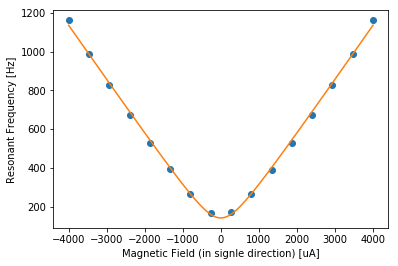

compensation current = -0.8683812308474811
compensation current error = 14.944734976553502


In [676]:
# X coil

field_zeroing(path = "After degaussing/Coil_X_scan/", fit_model = 'sqrt', 
                  show_frequencies = True, show_lorentz_fit = False);

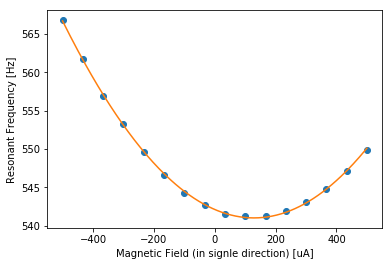

compensation current = 128.71942741441813
compensation current error = 1.481412409371887


In [688]:
# Y coil 

field_zeroing(path = "After degaussing/Coil_Y_scan/", fit_model = 'sqrt', 
                  show_frequencies = True, show_lorentz_fit = False);

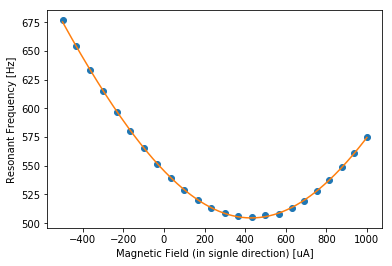

compensation current = 430.0876330404962
compensation current error = 0.9905913190887566


In [703]:
# Z coil 

field_zeroing(path = "After degaussing/Coil_Z_Y_zeroed/", fit_model = 'sqrt', 
                  show_frequencies = True, show_lorentz_fit = False);

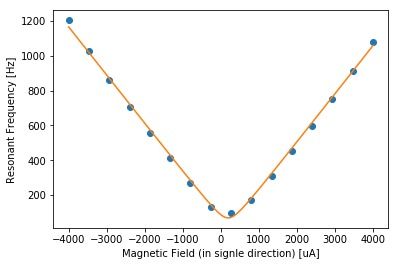

compensation current = 192.89207176092347
compensation current error = 18.957523561750584


In [705]:
# X coil after zeroing Y and Z fields

field_zeroing(path = "After degaussing/Coil_X_scan_fields_zeroed/", fit_model = 'sqrt', 
                  show_frequencies = True, show_lorentz_fit = False);

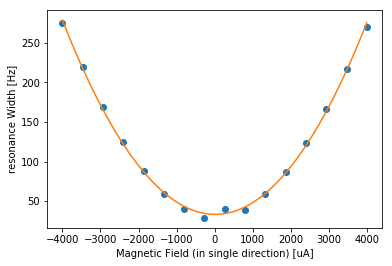

minimal width = 33.22901513688361
compensation current error = 1.469304992206605


In [706]:
resonance_width(path = "After degaussing/Coil_X_scan/", show_width = True, show_lorentz_fit = False);

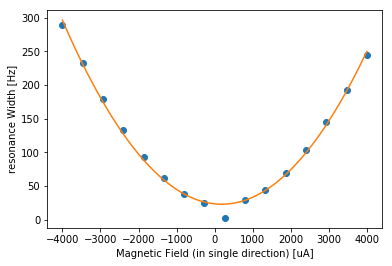

minimal width = 22.791860284748108
compensation current error = 2.608314968423952


In [707]:
resonance_width(path = "After degaussing/Coil_X_scan_fields_zeroed/", show_width = True, show_lorentz_fit = False);

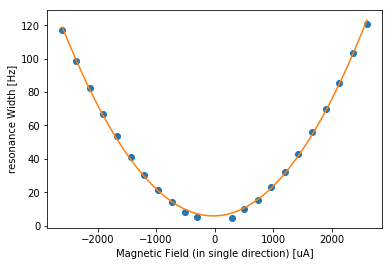

minimal width = 5.8652736633581615
compensation current error = 0.4906378037829641


In [708]:
resonance_width(path = "Before degaussing/Coil_X_scan_fields_zeroed/", show_width = True, show_lorentz_fit = False);

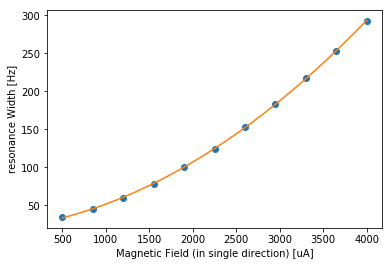

minimal width = 15.68108485153434
compensation current error = 2.0431035372414295


In [710]:

resonance_width(
    path = "Before degaussing/Tuned_to_centere_of_Rb_line/Rb_polarization/pump_wavelength_384.2297_THz/pump_135_mW/",
    show_width = True, show_lorentz_fit = False);


In [451]:
for i in range(len(lin_fits)):
    print('Slopes in Hz/uA = ',lin_fits[i][0], ', sigma = ', np.sqrt(lin_fits_cov[i,0,0]) )

Slopes in Hz/uA =  0.28331073695497466 , sigma =  0.0032934644206434518
Slopes in Hz/uA =  0.28037039984111645 , sigma =  0.0031536720007132907
Slopes in Hz/uA =  0.27694420553952837 , sigma =  0.0025486672286274556
Slopes in Hz/uA =  0.271575682776268 , sigma =  0.0019402594716960984
Slopes in Hz/uA =  0.26784993940243823 , sigma =  0.00233027797228574
Slopes in Hz/uA =  0.2660152719750707 , sigma =  0.0018158088377196405


# Do zrobienia na podstawie nowych fitów

Powtórzyć wykres częstość rezonansowa vs prąd (a najlepiej pole magnetyczne)

Obliczyć czynniki żyromagnetyczne

# Shield magnetisation check

In [499]:
directory = 'After degaussing (broken wire)/'
files_he_pol = glob.glob(directory+"*.dat")
files_he_pol                   

['After degaussing (broken wire)\\Ch_1__Curr_0_uA.dat',
 'After degaussing (broken wire)\\Ch_1__Curr_10000_uA.dat',
 'After degaussing (broken wire)\\Ch_1__Curr_20000_uA.dat',
 'After degaussing (broken wire)\\Ch_1__Curr_30000_uA.dat',
 'After degaussing (broken wire)\\Ch_1__Curr_40000_uA.dat',
 'After degaussing (broken wire)\\Ch_1__Curr_5000_uA.dat']



directory = 'After degaussing (broken wire)/'
files_he_pol = glob.glob(directory+"*.dat")
files_he_pol                   

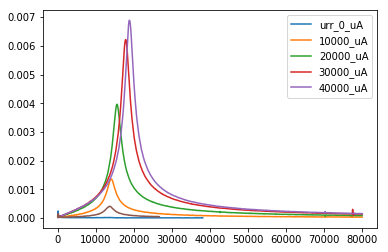

In [500]:
i = 0
for fn in files_he_pol:
    x = resonance(fn)
    plt.plot(x.freq,x.R, label = files_he_pol[i][-12:-4])
    #plt.yscale('log')
    plt.legend()
    i = i+1

In [ ]:
i = 0
for fn in files_he_pol:
    x = resonance(fn)
    plt.plot(x.freq,x.R, label = files_he_pol[i][-12:-4])
    plt.yscale('log')
    plt.legend()
    i = i+1